In [121]:
from src.data import make_dataset
from src.data import psql_operations
import numpy as np
import pandas as pd
from tpot.builtins import ZeroCount
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from tpot.builtins import StackingEstimator


weeks = [str(x) for x in range(1, 17)]
year = '2017'
# loading df
db_connection = psql_operations.PostgresConnection()
rbDf = db_connection.get_db_data('SELECT * FROM rbs_v2')
qbDf = db_connection.get_db_data('SELECT * FROM qbs_v2')
# setting columns that duplicate QB columns in the RB data to zero to allow for data cleaning
for col in ['score_for', 'score_against', 'win_loss']:
    rbDf[col] = 0
cleaner = make_dataset.DataCleaner()
print('Initially cleaning and aggregating the RB data')
aggRbDf = cleaner.clean_data(rbDf, 'rbs_v2')

print('Initially cleaning and aggregating the QB data')
aggQbDf = cleaner.clean_data(qbDf, 'qbs_v2')

print('getting maps and stuff from the DB')
winnings_list = []
vegas_winnings_list = []
accuracy_list = []
vegas_accuracy_list = []
for week in weeks:
    print(f'calculating week {week}...')

    trainRb_Qb = pd.merge(aggQbDf, aggRbDf, on='game_id', suffixes=('_qb', '_rb')).sort_values('total_touches_rb')
    trainRb_Qb = trainRb_Qb.drop_duplicates(subset='game_id')
    testing_data = cleaner.get_testing_data(aggRbDf, aggQbDf, week, year)
    trainRb_Qb = trainRb_Qb.drop('game_id', 1)

    training_features = trainRb_Qb.drop('win_loss', axis=1).values
    training_target = trainRb_Qb['win_loss'].values
    prediction_features = testing_data.drop('win_loss', axis=1).values

    # Score on the training set was:0.6203702298990865
    pipeline = make_pipeline(RFE(estimator=ExtraTreesClassifier(criterion="entropy", max_features=0.6500000000000001, n_estimators=100), step=0.9500000000000001),
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf=15, min_samples_split=18)),
    KNeighborsClassifier(n_neighbors=68, p=1, weights="distance"))

    pipeline.fit(training_features, training_target)
    # 1 as a prediction means the home team won
    predictions = pipeline.predict(prediction_features)
    confidences = pipeline.predict_proba(prediction_features)

    id_to_short_team = {team_id: team for team_id, team in zip(cleaner.team_map['team_id'], cleaner.team_map['team'])}

    # include confidence scores in this zip
    halfway_index = int(len(predictions)/2)
    
    # predictions
    round_1_predictions = []
    round_2_predictions = []
    current_index = 0
    for home_team_id, away_team_id, prediction in zip(list(testing_data['team_id_qb']), list(testing_data['team_id_away_qb']), predictions):
        home = id_to_short_team[home_team_id].upper()
        away = id_to_short_team[away_team_id].upper()
        # avoiding 2 loops, so switch rounds lives here:
        if current_index < halfway_index:
            # round 1
            if prediction == 1:
                round_1_predictions.append(home)
            else:
                round_1_predictions.append(away)
        else:
            if prediction == 1:
                round_2_predictions.append(home)
            else:
                round_2_predictions.append(away)
        current_index += 1

    winning_team_predictions = []
    winning_team_confidences = []
    for round1_conf, round2_conf, round1, round2 in zip(confidences[:halfway_index], confidences[halfway_index:], round_1_predictions, round_2_predictions):
        round1_conf = max(round1_conf)
        round2_conf = max(round2_conf)
        # both rounds of prediction agree, take the average of the confidences
        if round1 == round2:
            winning_team_predictions.append(round1)
            winning_team_confidences.append(np.average([round1_conf, round2_conf]))
        # rounds of prediction don't agree, therefore take the difference of the confidences
        else:
            if round1_conf > round2_conf:
                winning_team_predictions.append(round1)
                winning_team_confidences.append(round1_conf - round2_conf)
            else:
                winning_team_predictions.append(round2)
                winning_team_confidences.append(round2_conf - round1_conf)

    results_df = db_connection.get_db_data(f'SELECT winner FROM results WHERE week={week}')
    team_to_abbr = {
        'raiders': 'oak',
        'patriots': 'ne',
        'bills': 'buf',
        'texans': 'hou',
        'saints': 'no',
        'panthers': 'car',
        'bengals': 'cin',
        'browns': 'cle',
        'packers': 'gb',
        'lions': 'det',
        'seahawks': 'sea',
        'jaguars': 'jax',
        'jets': 'nyj',
        'chiefs': 'kc',
        'broncos': 'den',
        'dolphins': 'mia',
        'buccaneers': 'tb',
        'vikings': 'min',
        'cardinals': 'ari',
        'giants': 'nyg',
        'titans': 'ten',
        'steelers': 'pit',
        'colts': 'ind',
        'ravens': 'bal',
        'cowboys': 'dal',
        'chargers': 'lac',
        'rams': 'lar',
        '49ers': 'sf',
        'bears': 'chi',
        'redskins': 'wsh',
        'eagles': 'phi',
        'falcons': 'atl'
    }

    print('assessing accuracy of the predictions')
    results = [team_to_abbr[long_team].upper() for long_team in list(results_df['winner'].values)]
    correct_predictions = []
    for team in winning_team_predictions:
        correct = True
        if team not in results: correct = False
        correct_predictions.append(correct)

    percent_money_allocation = [x/sum(winning_team_confidences) for x in winning_team_confidences]
    vegas_percent_money_allocation = [1/len(winning_team_confidences)] * len(winning_team_confidences)

    odds_df = db_connection.get_db_data('SELECT * FROM \"2017_odds\" WHERE week=' + week)
    
    correct_vegas_predictions = []
    for team in list(odds_df['favoriteteam'].values):
        correct = True
        if team not in results: correct = False
        correct_vegas_predictions.append(correct)
    
    # calculating model winnings
    total_winnings = 0
    for correct, stake, predicted_team in zip(correct_predictions, percent_money_allocation, winning_team_predictions):
        fav_team = ''
        fav_odds = ''
        und_odds = ''
        winnings = 0
        stake *= 1000
        for i, row in odds_df.iterrows():
            if predicted_team in list(row):
                fav_team = row['favoriteteam']
                fav_odds = row['favorite']
                und_odds = row['underdog']

        if correct and predicted_team == fav_team:
            winnings = stake / (fav_odds / 100) + stake
        elif correct and predicted_team != fav_team:
            winnings = stake * (und_odds / 100) + stake
        else:
            winnings = 0
            
        total_winnings += winnings
        
    # calculating vegas winnings
    total_vegas_winnings = 0
    for correct, stake, predicted_team in zip(correct_vegas_predictions, vegas_percent_money_allocation, list(odds_df.loc[:, 'favoriteteam'])):
        fav_team = ''
        fav_odds = ''
        und_odds = ''
        winnings = 0
        stake *= 1000
        for i, row in odds_df.iterrows():
            if predicted_team in list(row):
                fav_team = row['favoriteteam']
                fav_odds = row['favorite']
                und_odds = row['underdog']

        if correct and predicted_team == fav_team:
            winnings = stake / (fav_odds / 100) + stake
        elif correct and predicted_team != fav_team:
            winnings = stake * (und_odds / 100) + stake
        else:
            winnings = 0

        total_vegas_winnings += winnings
        
    total_prediction_accuracy = np.average(correct_predictions)
    total_vegas_prediction_accuracy = np.average(correct_vegas_predictions)
    
    winnings_list.append(total_winnings)
    vegas_winnings_list.append(total_vegas_winnings)
    accuracy_list.append(total_prediction_accuracy)
    vegas_accuracy_list.append(total_vegas_prediction_accuracy)

Initially cleaning and aggregating the RB data
Initially cleaning and aggregating the QB data
getting maps and stuff from the DB
calculating week 1
assessing correctness of the predictions
calculating week 2
assessing correctness of the predictions
calculating week 3
assessing correctness of the predictions
calculating week 4
assessing correctness of the predictions
calculating week 5
assessing correctness of the predictions
calculating week 6
assessing correctness of the predictions
calculating week 7
assessing correctness of the predictions
calculating week 8
assessing correctness of the predictions
calculating week 9
assessing correctness of the predictions
calculating week 10
assessing correctness of the predictions
calculating week 11
assessing correctness of the predictions
calculating week 12
assessing correctness of the predictions
calculating week 13
assessing correctness of the predictions
calculating week 14
assessing correctness of the predictions
calculating week 15
assess

Calculating vegas favorite betting

In [122]:
# libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
 
# Create a dataset
graph_titles=['Accuracy Per Week', 'Model Rolling Average Return']
df = pd.DataFrame({
    "Titles": np.repeat(graph_titles, 16),
    "Week": list(range(1, 17)) * 2,
    "Accuracy": np.array(winnings_per_week + percent_winnings_rolling_average)
})
 
g = sns.FacetGrid(df, col='Titles', hue='Titles', size=5)
plt.xlabel('Week', size=14)
g = g.map(plt.grid, alpha=0.2)
g = g.map(plt.plot, 'Week', 'Return')
g = g.map(plt.fill_between, 'Week', 'Return', alpha=0.2)
g = g.set_xlabels('Week', size=14)
g = g.set_ylabels('Return (%)', size=14)
g = g.set_titles("{col_name}", size=14)
[plt.setp(ax.get_xticklabels(), size=12) for ax in g.axes.flat]
[plt.setp(ax.get_yticklabels(), size=12) for ax in g.axes.flat]

plt.subplots_adjust(top=0.80)
g = g.fig.suptitle('Model Return by Week', size=20)

plt.xticks(range(1,17), range(1,17))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('2017_winnings')
plt.show()

SyntaxError: invalid syntax (<ipython-input-122-2d9006b86c73>, line 14)

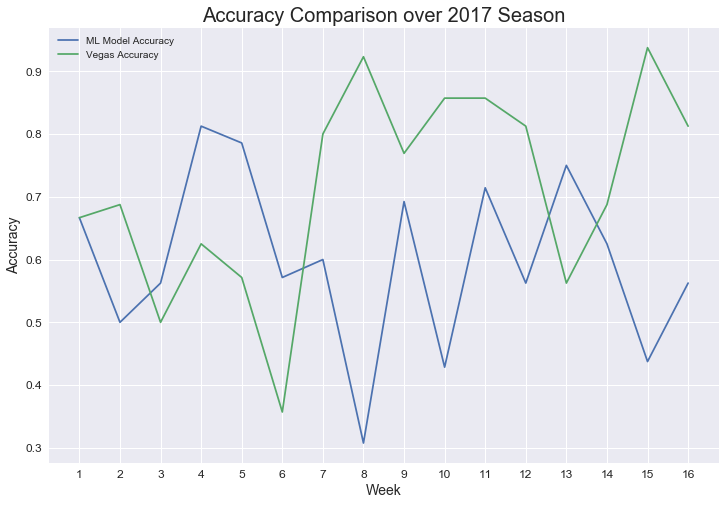

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

weeks = [x for x in range(1, 17)]
original_weeks = [x for x in range(0, 16)]
mpl.style.use('seaborn')
plt.figure(figsize=(12,8))
pal = sns.color_palette("Set1")

plt.plot(accuracy_list, label='ML Model Accuracy')
plt.plot(vegas_accuracy_list, label='Vegas Accuracy')
plt.ylabel('Accuracy', size=14)
plt.xlabel('Week', size=14)
plt.title('Accuracy Comparison over 2017 Season', size=20)
plt.xticks(original_weeks, weeks, size=12)
plt.yticks(size=12)
plt.legend()
plt.savefig('2017_accuracy')
plt.show()

In [125]:
percent_winnings_rolling_average = []
vegas_percent_winnings_rolling_average = []
for i, total_bet in enumerate(range(1000, 17000, 1000)):
    percent_winnings_rolling_average.append((sum(winnings_list[:i+1]) - total_bet)/total_bet)
    vegas_percent_winnings_rolling_average.append((sum(vegas_winnings_list[:i+1]) - total_bet)/total_bet)
winnings_per_week = [(x - 1000)/1000 for x in winnings_list]
vegas_winnings_per_week = [(x - 1000)/1000 for x in vegas_winnings_list]

In [42]:
sb_df = pd.concat([homeDf[homeDf['game_id'] == 'NE_BUF'], homeDf[homeDf['game_id'] == 'PHI_OAK']])
print(pipeline.predict_proba(sb_df.drop(['win_loss', 'game_id', 'index_qb','index_rb'], 1).values))

[[0.3433842  0.6566158 ]
 [0.48194215 0.51805785]]


In [172]:
df_dict = {'% Return Per Week': [x * 100 for x in winnings_per_week + vegas_winnings_per_week],
          'Rolling Average % Return': [x * 100 for x in percent_winnings_rolling_average + vegas_percent_winnings_rolling_average],
          '% Accuracy': [x * 100 for x in accuracy_list + vegas_accuracy_list],
          'Predictor': np.repeat(['ML Model', 'Vegas'], 16),
          'Week': list(range(1, 17)) * 2}
pairplot = pd.DataFrame(df_dict)

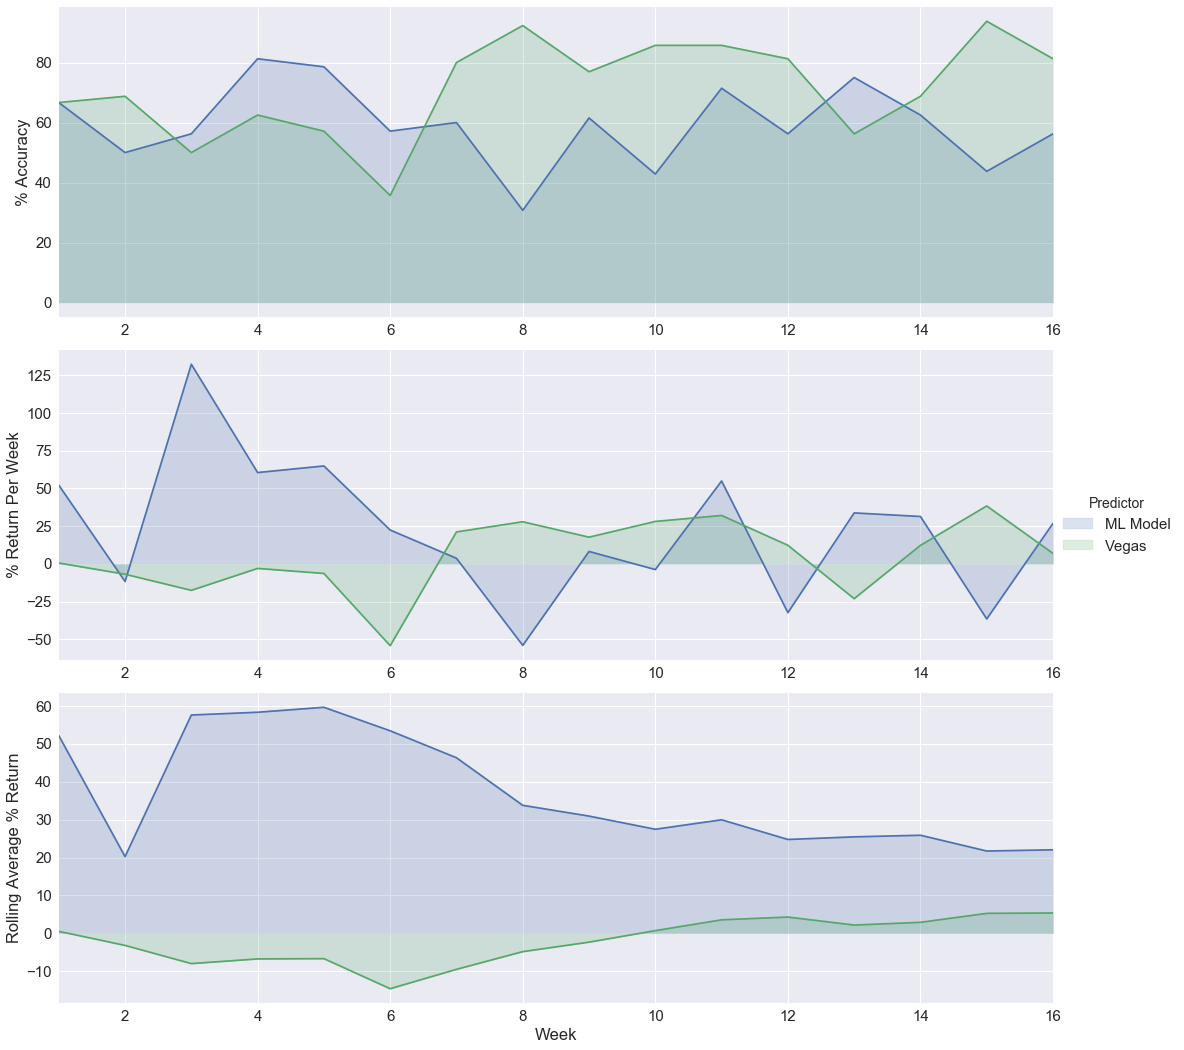

In [189]:
sns.set(font_scale=1.5)
g = sns.PairGrid(pairplot, y_vars=['% Accuracy', '% Return Per Week', 'Rolling Average % Return'], x_vars='Week', hue='Predictor', size=5, aspect=3)
g = g.map(plt.plot)
g = g.map(plt.fill_between, alpha=0.2)
g = g.add_legend()
for ax in g.axes.flat:
    _ = plt.setp(ax.get_xticklabels(), visible=True)
    ax.set_xlim(1,16)
plt.savefig('2017_all_results')
plt.show()

In [159]:
# sns.axes_style()
sns.set_style({"xtick.major.size": 12,
              'ytick.major.size': 12})

In [204]:
pairplot.index.name = 'Week'
pairplot[['Rolling Average % Return']][:16]

,Rolling Average % Return
Week,
1,52.206101
2,20.243103
3,57.624162
4,58.354759
5,59.666685
6,53.456817
7,46.340541
8,33.783316
9,30.939303


In [203]:
pairplot.index = [x - 1 for x in pairplot.index]

In [206]:
0.6566158 - 0.51805785 + .5

0.6385579499999999